In [3]:
import torch
from torch_geometric.data import Data, DataLoader, Dataset
import torch.nn.functional as F
import random 
import networkx as nx
import numpy as np
from torch_geometric.nn import NNConv
from torch.nn import Linear
from matplotlib import pyplot as plt

In [4]:
def generate_polygon(n, radius=1):
    node_pos = [(radius * np.cos(2 * np.pi * i / n),
                 radius * np.sin(2 * np.pi * i / n)) for i in range(n)]
    x = torch.tensor(node_pos,dtype=torch.float)
    return x

def generate_randPos(n, radius=1):
    node_pos = [(random.uniform(-1, 1),
                 random.uniform(-1, 1)) for i in range(n)]
    x = torch.tensor(node_pos,dtype=torch.float)
    return x

def generate_edgelist(size):
    return [(i, j) for i in range(size) for j in range(i + 1, size)]

def generate_eAttr(G, com_edge_list):
    path_length = dict(nx.all_pairs_shortest_path_length(G))
    max_length = 0
    for source in path_length:
        for target in path_length[source]:
            if path_length[source][target] > max_length:
                max_length = path_length[source][target]
    L = 2/max_length
    K = 1
    edge_attr = []
    for i in com_edge_list:
        d = path_length[i[0]][i[1]]
        l = L * d #l = L * d
        k = K/(d**2) 
        edge_attr.append([l,k])
    out = torch.tensor(edge_attr, dtype=torch.float)
    return out

def generate_graph(size):
    while True:
#         G = nx.binomial_graph(size, random.random(),directed=False)
        G = nx.random_powerlaw_tree(size,3,tries=10000)
        com_edge_list = generate_edgelist(size)
        try:
            edge_attr = generate_eAttr(G, com_edge_list)
        except KeyError:
            continue
        except ZeroDivisionError:
            continue
        edge_index = torch.tensor(com_edge_list, dtype=torch.long)
        x = generate_randPos(size)
        data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)
        return G, data

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = NNConv(2, 16, Linear(2, 2*16))
#         self.conv2 = NNConv(16, 32, Linear(2, 16*32))
#         self.conv3 = NNConv(32, 64, Linear(2, 32*64))
#         self.conv4 = NNConv(16+32+64, 2, Linear(2, (16+32+64)*2))
        self.conv2 = NNConv(16,2,Linear(2,16*2))

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x1 = F.relu(self.conv1(x, edge_index, edge_attr))
        x2 = F.relu(self.conv2(x1, edge_index, edge_attr))
#         x3 = F.relu(self.conv3(x2, edge_index, edge_attr))
#         x = torch.cat((x1, x2, x3), dim=1)
        
#         x4 = F.relu(self.conv4(x, edge_index, edge_attr))
        
        return x2

class EnergyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, data):
        energy = 0
        offset = 0
        edge_attr = data.edge_attr
        n = data.x.size()[0]
        x = p[offset:offset+n, 0]
        y = p[offset:offset+n, 1]
        offset += n
        l = edge_attr[:, 0]
        k = edge_attr[:, 1]
        for e, (i, j) in enumerate(generate_edgelist(n)):
            term1 = (x[i] - x[j]) ** 2
            term2 = (y[i] - y[j]) ** 2
            term3 = l[e] ** 2
            term4 = 2 * l[e] * (term1 + term2).sqrt()
            energy += k[e] / 2 * (term1 + term2 + term3 - term4)
        return energy
    
# def train(model, criterion, optimizer,loader):
#     model.train()
#     loss_all = 0
#     for data in loader:
#         data = data.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output,data)
#         loss.backward()
#         loss_all += data.num_graphs * loss.item()
#         optimizer.step()
#     return loss_all / len(data_list)

# def evaluate(model,data):
#     model.eval()
#     with torch.no_grad():
#         data = data.to(device)
#         pred = model(data).detach().cpu().numpy()
#     return pred


def graph_vis(G, node_pos, file_name):
    i = 0
    for n, p in node_pos:
        G.nodes[i]['pos'] = (n,p)
        i += 1
    pos = nx.get_node_attributes(G,'pos')
    plt.figure()
    nx.draw(G, pos)
    plt.savefig(file_name) 

0 tensor(2.0537, grad_fn=<AddBackward0>)
1000 tensor(1.5647, grad_fn=<AddBackward0>)
2000 tensor(1.2159, grad_fn=<AddBackward0>)
3000 tensor(0.9699, grad_fn=<AddBackward0>)
4000 tensor(0.7946, grad_fn=<AddBackward0>)
5000 tensor(0.6676, grad_fn=<AddBackward0>)
6000 tensor(0.5735, grad_fn=<AddBackward0>)
7000 tensor(0.5029, grad_fn=<AddBackward0>)
8000 tensor(0.4511, grad_fn=<AddBackward0>)
9000 tensor(0.4133, grad_fn=<AddBackward0>)
10000 tensor(0.3844, grad_fn=<AddBackward0>)
11000 tensor(0.3619, grad_fn=<AddBackward0>)
12000 tensor(0.3454, grad_fn=<AddBackward0>)
13000 tensor(0.3347, grad_fn=<AddBackward0>)
14000 tensor(0.3286, grad_fn=<AddBackward0>)
15000 tensor(0.3258, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

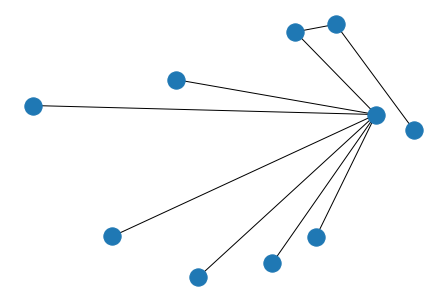

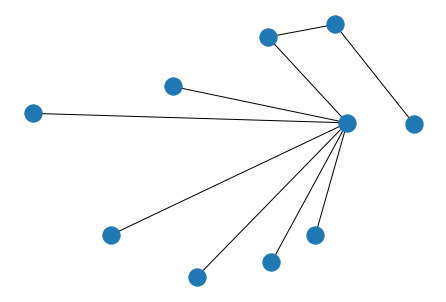

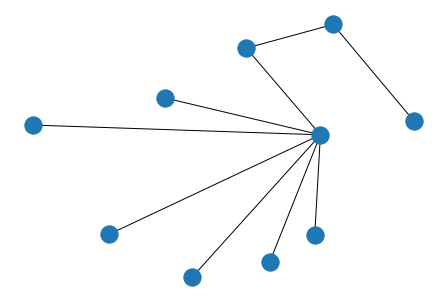

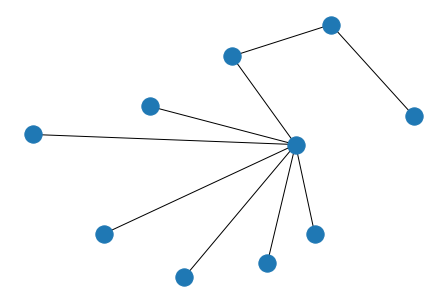

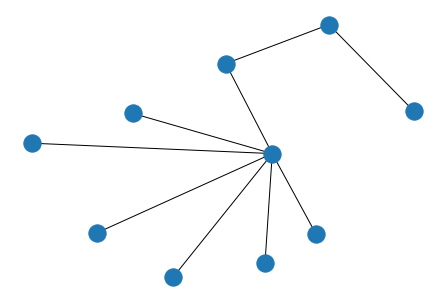

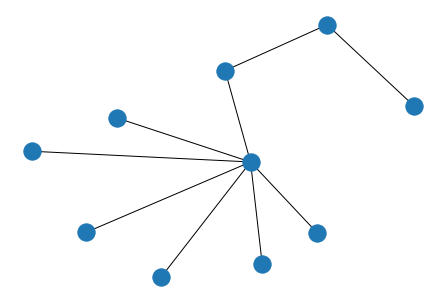

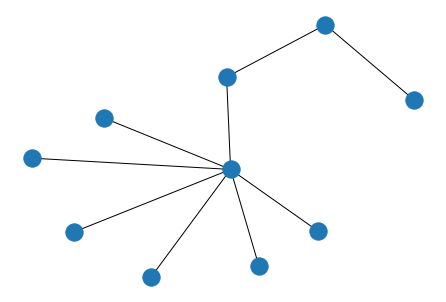

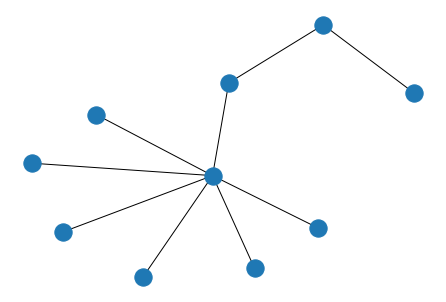

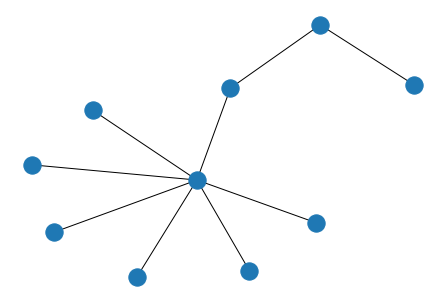

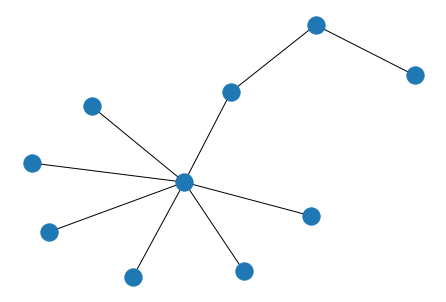

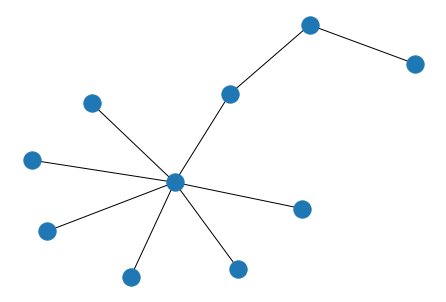

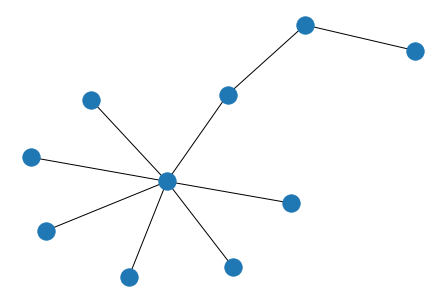

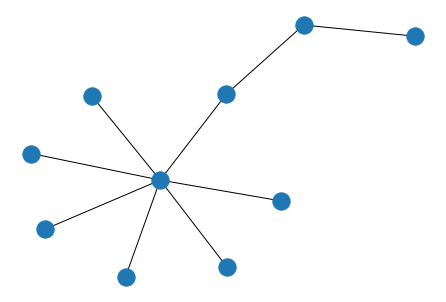

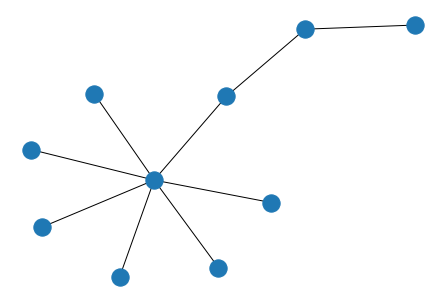

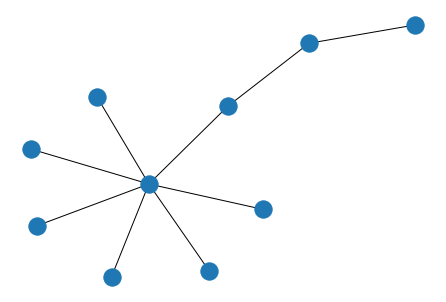

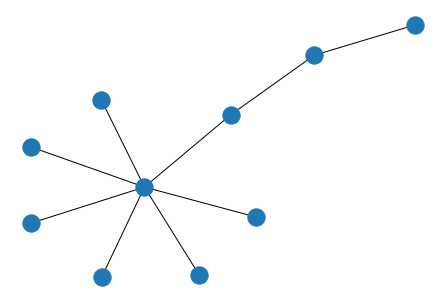

In [6]:
G, data = generate_graph(10)
optimizer = torch.optim.Adam([data.x.requires_grad_()], lr=0.00005)
criterion = EnergyLoss()
epoch = 1000000
loss_iters = []
for i in range(epoch):
    optimizer.zero_grad()
    loss = criterion(data.x,data)
    loss.backward()
    optimizer.step()
    loss_iters.append(loss.item())
    if i % 1000 == 0:
        print(i,loss)
        graph_vis(G, data.x, f'test_opt_data2/epoch_{i}.png')
        